<a href="https://colab.research.google.com/github/l-isaro/air-pollution-beinjing/blob/main/air_quality_forecasting_starter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook

In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from math import sqrt

In [37]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [38]:
# Data shapes and types
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("\nTrain data types:\n", train.dtypes)
print("\nTest data types:\n", test.dtypes)

# Summary stats for train
print("\nTrain summary:\n", train.describe())

# Missing values
print("\nMissing in train:\n", train.isna().sum())
print("\nMissing in test:\n", test.isna().sum())

# Convert 'datetime' to datetime type
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

# Check time continuity
train_time_diff = train['datetime'].diff().dropna()
test_time_diff = test['datetime'].diff().dropna()
print("\nTrain time gaps unique:", train_time_diff.unique())
print("Test time gaps unique:", test_time_diff.unique())
print("Last train datetime:", train['datetime'].max())
print("First test datetime:", test['datetime'].min())

Train shape: (30676, 12)
Test shape: (13148, 11)

Train data types:
 No            int64
DEWP        float64
TEMP        float64
PRES        float64
Iws         float64
Is          float64
Ir          float64
datetime     object
cbwd_NW     float64
cbwd_SE     float64
cbwd_cv     float64
pm2.5       float64
dtype: object

Test data types:
 No            int64
DEWP        float64
TEMP        float64
PRES        float64
Iws         float64
Is          float64
Ir          float64
datetime     object
cbwd_NW     float64
cbwd_SE     float64
cbwd_cv     float64
dtype: object

Train summary:
                  No          DEWP          TEMP          PRES           Iws  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean   15338.500000     -0.029431     -0.062712      0.013612      0.030542   
std     8855.542765      0.994087      1.015193      1.008991      1.018337   
min        1.000000     -2.135153     -2.578070     -2.380821     -0.468688   
25%     7669

In [ ]:
# --- Imports & setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL  # more robust than seasonal_decompose for irregular freq

sns.set_context("talk")
sns.set_style("whitegrid")

# --- 0) Ensure datetime & sorting
df = train.copy()
if not np.issubdtype(df["datetime"].dtype, np.datetime64):
    df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
df = df.sort_values("datetime").reset_index(drop=True)

# --- 1) Set index for all time-based plots
df = df.set_index("datetime")

# --- 2) Keep an analysis copy with forward-fill (viz only)
viz = df.ffill()

# --- 3) PM2.5 time series
ax = viz["pm2.5"].plot(figsize=(12, 6), title="PM2.5 Over Time")
ax.set_ylabel("PM2.5 (original units)")
plt.tight_layout()
plt.show()

# --- 4) Feature distributions (only numeric columns; skip all-NaN)
num_cols = viz.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) > 0:
    viz[num_cols].hist(figsize=(12, 10), bins=20)
    plt.suptitle("Feature Distributions", y=1.02)
    plt.tight_layout()
    plt.show()

# --- 5) Correlation heatmap (drop obvious ID-like cols if present)
drop_maybe = [c for c in ["No"] if c in viz.columns]
corr = viz.drop(columns=drop_maybe, errors="ignore").select_dtypes(include=[np.number]).corr()

# Show only one triangle for readability
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", linewidths=0.5, square=True, cbar_kws={"shrink": .75})
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# --- 6) Boxplots (numeric features)
if len(num_cols) > 0:
    # Using seaborn for a single, neat figure
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=viz[num_cols], orient="h", showfliers=True)
    plt.title("Boxplots for Numerical Features")
    plt.tight_layout()
    plt.show()

# --- 7) Seasonal structure (STL)
# Make sure we have regular hourly data; if not, resample to hourly
if viz.index.inferred_freq is None:
    # if timestamps are near-hourly, round then resample; otherwise just resample
    pm25_hourly = viz["pm2.5"].resample("H").mean().interpolate(limit_direction="both")
else:
    pm25_hourly = viz["pm2.5"]

# Choose a sensible period:
# - daily seasonality for hourly data = 24
# - weekly seasonality for hourly data = 24*7
period = 24 * 7  # weekly pattern is often meaningful for air quality

pm25_clean = pm25_hourly.dropna()
if pm25_clean.size >= 2 * period:
    stl = STL(pm25_clean, period=period, robust=True)
    res = stl.fit()
    res.plot()
    plt.suptitle("PM2.5 STL Decomposition (Trend, Seasonal, Residual)")
    plt.tight_layout()
    plt.show()
else:
    print(f"Not enough data for STL with period={period}. Need at least {2*period} points; have {pm25_clean.size}.")


In [ ]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [39]:
TARGET = 'pm2.5'
DROP_COLS = ['No']

df = train.dropna(subset=[TARGET]).copy()
test = test.copy()
for c in DROP_COLS:
    if c in df.columns: df.drop(columns=c, inplace=True)
    if c in test.columns: test.drop(columns=c, inplace=True)

df['datetime'] = pd.to_datetime(df['datetime']); test['datetime'] = pd.to_datetime(test['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)
test = test.sort_values('datetime').reset_index(drop=True)

def add_time_features(frame):
    f = frame.copy()
    f['hour'] = f['datetime'].dt.hour
    f['dayofweek'] = f['datetime'].dt.dayofweek
    f['month'] = f['datetime'].dt.month
    f['hour_sin'] = np.sin(2*np.pi*f['hour']/24)
    f['hour_cos'] = np.cos(2*np.pi*f['hour']/24)
    f['dow_sin']  = np.sin(2*np.pi*f['dayofweek']/7)
    f['dow_cos']  = np.cos(2*np.pi*f['dayofweek']/7)
    f['mon_sin']  = np.sin(2*np.pi*(f['month']-1)/12)
    f['mon_cos']  = np.cos(2*np.pi*(f['month']-1)/12)
    return f

df = add_time_features(df); test = add_time_features(test)

FEATURES = [c for c in df.columns if c not in ['pm2.5','datetime'] and not c.endswith(('_ma6','_ma12','_ma24'))]
len(FEATURES), FEATURES[:10]

(18,
 ['DEWP',
  'TEMP',
  'PRES',
  'Iws',
  'Is',
  'Ir',
  'cbwd_NW',
  'cbwd_SE',
  'cbwd_cv',
  'hour'])

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [40]:
fixed_cut = pd.Timestamp('2013-01-01 00:00:00')
if df['datetime'].min() < fixed_cut < df['datetime'].max():
    VAL_START = fixed_cut
else:
    VAL_START = df['datetime'].quantile(0.85)

train_df = df[df['datetime'] < VAL_START].copy()
val_df   = df[df['datetime'] >= VAL_START].copy()

print("Split at:", VAL_START, "| Train rows:", len(train_df), "Val rows:", len(val_df))
print("Date range:", df['datetime'].min(), "→", df['datetime'].max())

train_medians = train_df[FEATURES].median()
train_df[FEATURES] = train_df[FEATURES].fillna(train_medians)
val_df[FEATURES]   = val_df[FEATURES].fillna(train_medians)

scaler = StandardScaler()
train_X = scaler.fit_transform(train_df[FEATURES].values)
val_X   = scaler.transform(val_df[FEATURES].values)

train_y = train_df[TARGET].values
val_y   = val_df[TARGET].values
train_time = train_df['datetime'].values
val_time   = val_df['datetime'].values

train_X.shape, val_X.shape

Split at: 2013-01-01 00:00:00 | Train rows: 24418 Val rows: 4337
Date range: 2010-01-02 00:00:00 → 2013-07-02 03:00:00


((24418, 18), (4337, 18))

In [41]:
WINDOW = 60
HORIZON = 0
print("Using WINDOW =", WINDOW)

def make_sequences(X, y, window=60, horizon=0):
    Xs, ys = [], []
    for i in range(window, len(X) - horizon):
        Xs.append(X[i-window:i, :])
        ys.append(y[i + horizon])
    return np.array(Xs), np.array(ys)

X_tr, y_tr = make_sequences(train_X, train_y, window=WINDOW, horizon=HORIZON)
X_va, y_va = make_sequences(val_X,   val_y,   window=WINDOW, horizon=HORIZON)
X_tr.shape, X_va.shape


Using WINDOW = 60


((24358, 60, 18), (4277, 60, 18))

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [42]:
inputs = keras.Input(shape=(X_tr.shape[1], X_tr.shape[2]))
x = layers.Masking(mask_value=0.0)(inputs)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.Dropout(0.15)(x)
x = layers.LSTM(64)(x)
x = layers.Dropout(0.15)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mse')

callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
]


In [43]:
EPOCHS = 50
BATCH_SIZE = 256
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_va, y_va),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2,
    callbacks=callbacks
)

val_pred = model.predict(X_va, verbose=0).squeeze()


Epoch 1/50
96/96 - 57s - 594ms/step - loss: 13799.1006 - val_loss: 16259.3799 - learning_rate: 1.0000e-03
Epoch 2/50
96/96 - 79s - 821ms/step - loss: 8342.8457 - val_loss: 12804.4795 - learning_rate: 1.0000e-03
Epoch 3/50
96/96 - 87s - 904ms/step - loss: 7998.3672 - val_loss: 12835.0098 - learning_rate: 1.0000e-03
Epoch 4/50
96/96 - 56s - 581ms/step - loss: 8016.6064 - val_loss: 12850.0625 - learning_rate: 1.0000e-03
Epoch 5/50
96/96 - 51s - 535ms/step - loss: 7849.7051 - val_loss: 11413.8555 - learning_rate: 1.0000e-03
Epoch 6/50
96/96 - 51s - 536ms/step - loss: 5510.7461 - val_loss: 8516.4756 - learning_rate: 1.0000e-03
Epoch 7/50
96/96 - 84s - 874ms/step - loss: 4387.9111 - val_loss: 7458.0977 - learning_rate: 1.0000e-03
Epoch 8/50
96/96 - 53s - 548ms/step - loss: 3807.5032 - val_loss: 7716.2012 - learning_rate: 1.0000e-03
Epoch 9/50
96/96 - 53s - 550ms/step - loss: 3420.9836 - val_loss: 6283.3076 - learning_rate: 1.0000e-03
Epoch 10/50
96/96 - 82s - 851ms/step - loss: 3137.9836 - v

In [44]:
val_rmse = sqrt(mean_squared_error(y_va, val_pred))
print(f"\nValidation RMSE: {val_rmse}")


Validation RMSE: 78.46177402925387


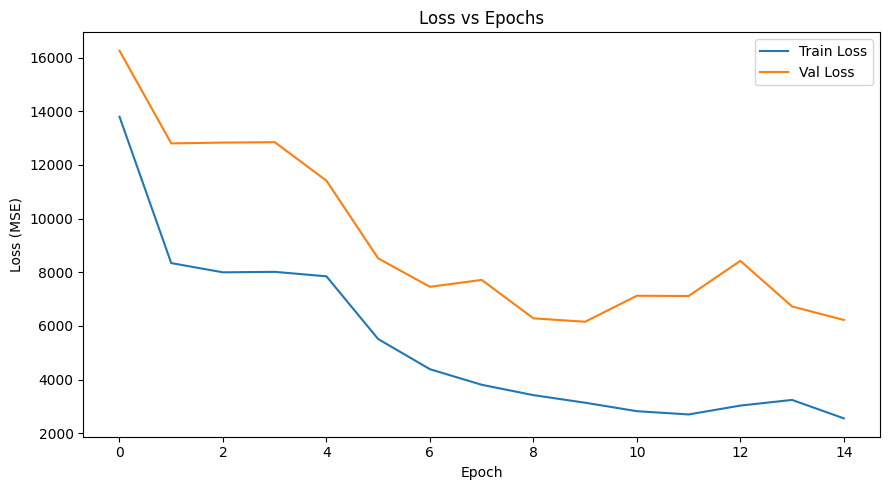

In [45]:
plt.figure(figsize=(9, 5))
plt.plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.tight_layout()
plt.show()

In [49]:

# ===== TEST SEQUENCES (match WINDOW) =====
full = pd.concat([df[['datetime'] + FEATURES], test[['datetime'] + FEATURES]], ignore_index=True).sort_values('datetime')
full_X = scaler.transform(full[FEATURES].values)
idx_map = {t: i for i, t in enumerate(full['datetime'].values)}

def make_test_sequences(full_X, full_time, end_times, window=60):
    Xs, valid_times = [], []
    for t in end_times:
        i = idx_map.get(t, None)
        if i is None or i < window:
            continue
        Xs.append(full_X[i-window:i, :])
        valid_times.append(t)
    return np.array(Xs), np.array(valid_times)

X_te, te_times = make_test_sequences(full_X, full['datetime'].values, test['datetime'].values, window=WINDOW)
X_te.shape, len(te_times)


((13148, 60, 18), 13148)

In [52]:
# Test predictions aligned to EXACT test order
test_pred = model.predict(X_te, verbose=0).squeeze()
pred_series = pd.Series(test_pred, index=pd.to_datetime(te_times))
ordered_pred = pred_series.reindex(pd.to_datetime(test['datetime'])).values

# light clipping
ordered_pred = np.clip(ordered_pred, 0, 1000)

# exact Kaggle format
try:
    row_id = test["datetime"].dt.strftime("%Y-%m-%d %-H:00:00")
except Exception:
    row_id = test["datetime"].dt.strftime("%Y-%m-%d %#H:00:00")

submission = pd.DataFrame({"row ID": row_id, "pm2.5": ordered_pred})
out_path = "submission/submission.csv"
submission.to_csv(out_path, index=False)
print("Saved:", out_path, submission.shape)
submission.head()

Saved: submission/submission.csv (13148, 2)


,row ID,pm2.5
0,2013-07-02 4:00:00,52.196259
1,2013-07-02 5:00:00,49.587437
2,2013-07-02 6:00:00,46.074764
3,2013-07-02 7:00:00,43.267544
4,2013-07-02 8:00:00,39.860012
